# Comparing Classifiers F1 Score and Overfitting for Loan Approval Systems

The goal of the project is to explore and compare 8 classifier algorithms for a loan approval automated system, based on their f1 scores and tendency to overfit. The compared classifiers are:
1. Logistic Regression (LR)
2. Linear Discriminant Analysis (LDA)
3. KNeighbors Classifier (KNN)
4. Decision Tree Classifier (DT)
5. Gaussian Naive Bayes (GNB)
6. Support Vector Classification (SVC)
7. Random Forest Classifier (RF)
8. Voting Classifier (VC) - Combining LR and RF

This is inspired by a conference paper of [S. Srivastava (2024)](https://ieeexplore.ieee.org/document/10866059), which compares between 5 algorithms based on accuracy scores. This research adds LDA, KNeighbors Classifier (KNN) and Gaussian Naive Bayes (GNB) to the comparison, and uses f1 scoring instead. 

Data analysed is from [Kaggle's Loan Approval Prediction Dataset](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset) by Archit Sharma.

*PS: This project is done in parallel to my studies for MSc in AI at the University of Essex Online (UoEO) for the sake of exploration and practice. No general claims or arguments are intended.*

## 1. Business Understanding

The project assumes an imaginary local startup, hypothetically named XFactor, specialising in financial services including cashless transactions, loans, credit assessment, and tailored financial advice. The company faces challenges in scaling operations, earning customer trust, and navigating the competitive financial sector. By embracing valid AI applications, XFactor can address these challenges while positioning itself as a forward-thinking, tech-driven player in the industry.

One of the key AI development areas for XFactor is automating their loan approval system. This project is done to evaluate possible algorithms to use in the system development.

## 2. Data Understanding

### 2.1 Importing libraries and loading the dataset

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [18]:
# Load the dataset
df = pd.read_csv('loan_approval_dataset.csv', index_col='loan_id')

# Column names have leading/trailing spaces, so we need to strip them
df = df.rename(columns=lambda x: x.strip()) 
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### 2.2 Exploratory data analysis (EDA)

#### 2.2.1 Univariate analysis

In [19]:
# Explore the variable types
df.dtypes

no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

In [20]:
# Explore descriptive statistics of the numerical columns
df.describe(include='int')

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


*Note:* *1. residential_assets_value has negative values. This further investigated in the cell below.*
*2. Variables have very different scales. Standardisation will be needed in data preparation for linear algorithms.*

In [21]:
# Investigate how many values are negative in the 'residential_assets_value' column and their distribution
(df['residential_assets_value'][df['residential_assets_value'] < 0]).value_counts()

residential_assets_value
-100000    28
Name: count, dtype: int64

*Note: All of the negative values in the 'residential_assets_value' column are of the value -100,000, and their count is 28, which is less than 1% of the instances. This is likely a data entry/storage error, and therefore safer to be removed. The removal will be done in the 3. Data Preparation phase.*

In [22]:
# Explore the descriptive statistics for categorical columns
df.describe(include='object')

,education,self_employed,loan_status
count,4269,4269,4269
unique,2,2,2
top,Graduate,Yes,Approved
freq,2144,2150,2656


In [23]:
# Check for missing values
df.isna().sum().sum()

np.int64(0)

*Note: The dataset has no missing values. Therefore, there is no need to handle missing values in data preparation.*

In [24]:
# Check for the balance of the target variable 'loan_status'
df['loan_status'].value_counts()/len(df['loan_status'])

loan_status
Approved    0.62216
Rejected    0.37784
Name: count, dtype: float64

*Note: The minority class (Rejected) represents roughly 38% of the dataset. For the sake of this project, this slight imbalance is treated only through setting balanced class weights for some models in the modeling phase.*

#### 2.2.2 Bivariate analysis

In [25]:
# Get the names of the numerical and categorical columns to use in exploration below
num_columns = df.select_dtypes(include='int64').columns
print(num_columns)
cat_columns = df.select_dtypes(include='object').columns.drop('loan_status')
print(cat_columns)

Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dtype='object')
Index(['education', 'self_employed'], dtype='object')


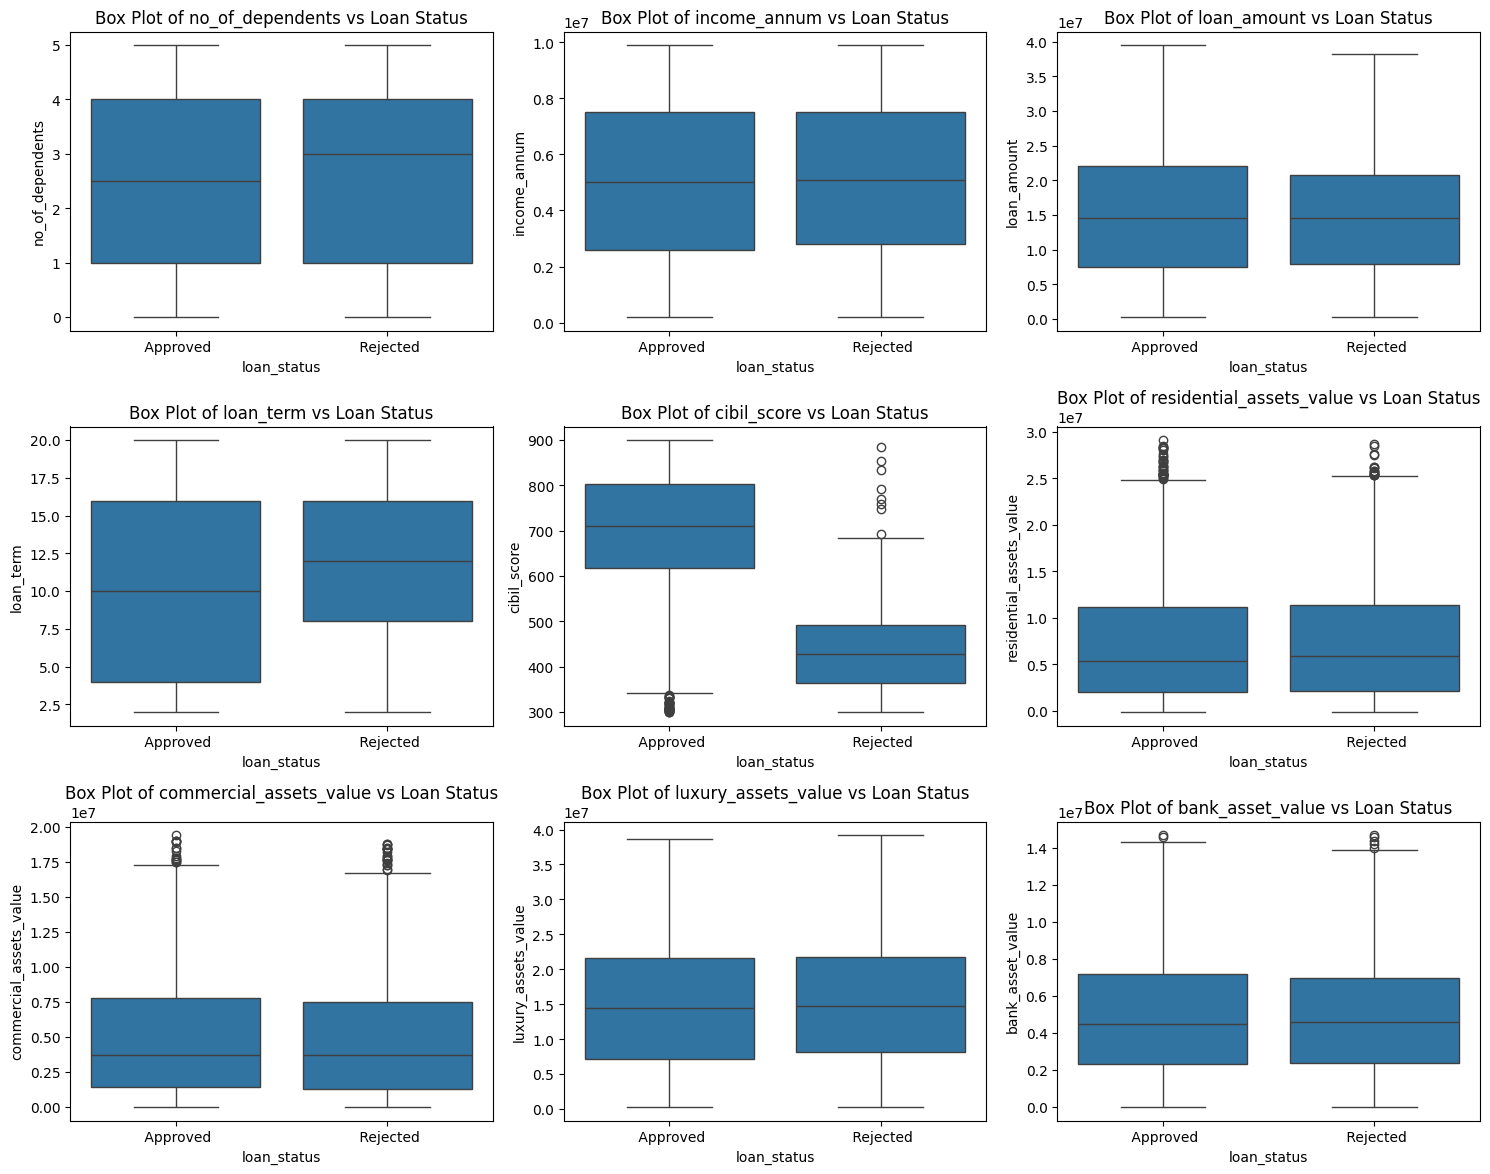

In [26]:
# Explore the relationship between the numerical variables and the target variable with box plots

# Define the grid size (3x3)
rows, cols = 3, 3  

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through each column and plot in the corresponding subplot
for i, col in enumerate(num_columns):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        sns.boxplot(x='loan_status', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'Box Plot of {col} vs Loan Status')

# Hide any unused subplots
for j in range(len(num_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

*Note: From the box plots, it can be noticed that the only variable that clearly varies across approved and rejected loans is cibil_score.* 

*"CIBIL Score is a three-digit numeric summary of your credit history. The score is derived using the credit history found in the CIBIL Report (also known as CIR i.e Credit Information Report). A CIR is an individual’s credit payment history across loan types and credit institutions over a period of time." - [TransUnion CIBIL](https://www.cibil.com/faq/understand-your-credit-score-and-report)*

In [27]:
# Explore the relationship between categorical variables and the target variable with crosstabs
for col in cat_columns:
    pivot_table = pd.crosstab(df['loan_status'], df[col])
    print(col)
    display(pivot_table)

education


education,Graduate,Not Graduate
loan_status,,
Approved,1339,1317
Rejected,805,808


self_employed


self_employed,No,Yes
loan_status,,
Approved,1318,1338
Rejected,801,812


*Note: The target variable does not clearly vary across the different categories of both categorical columns.*

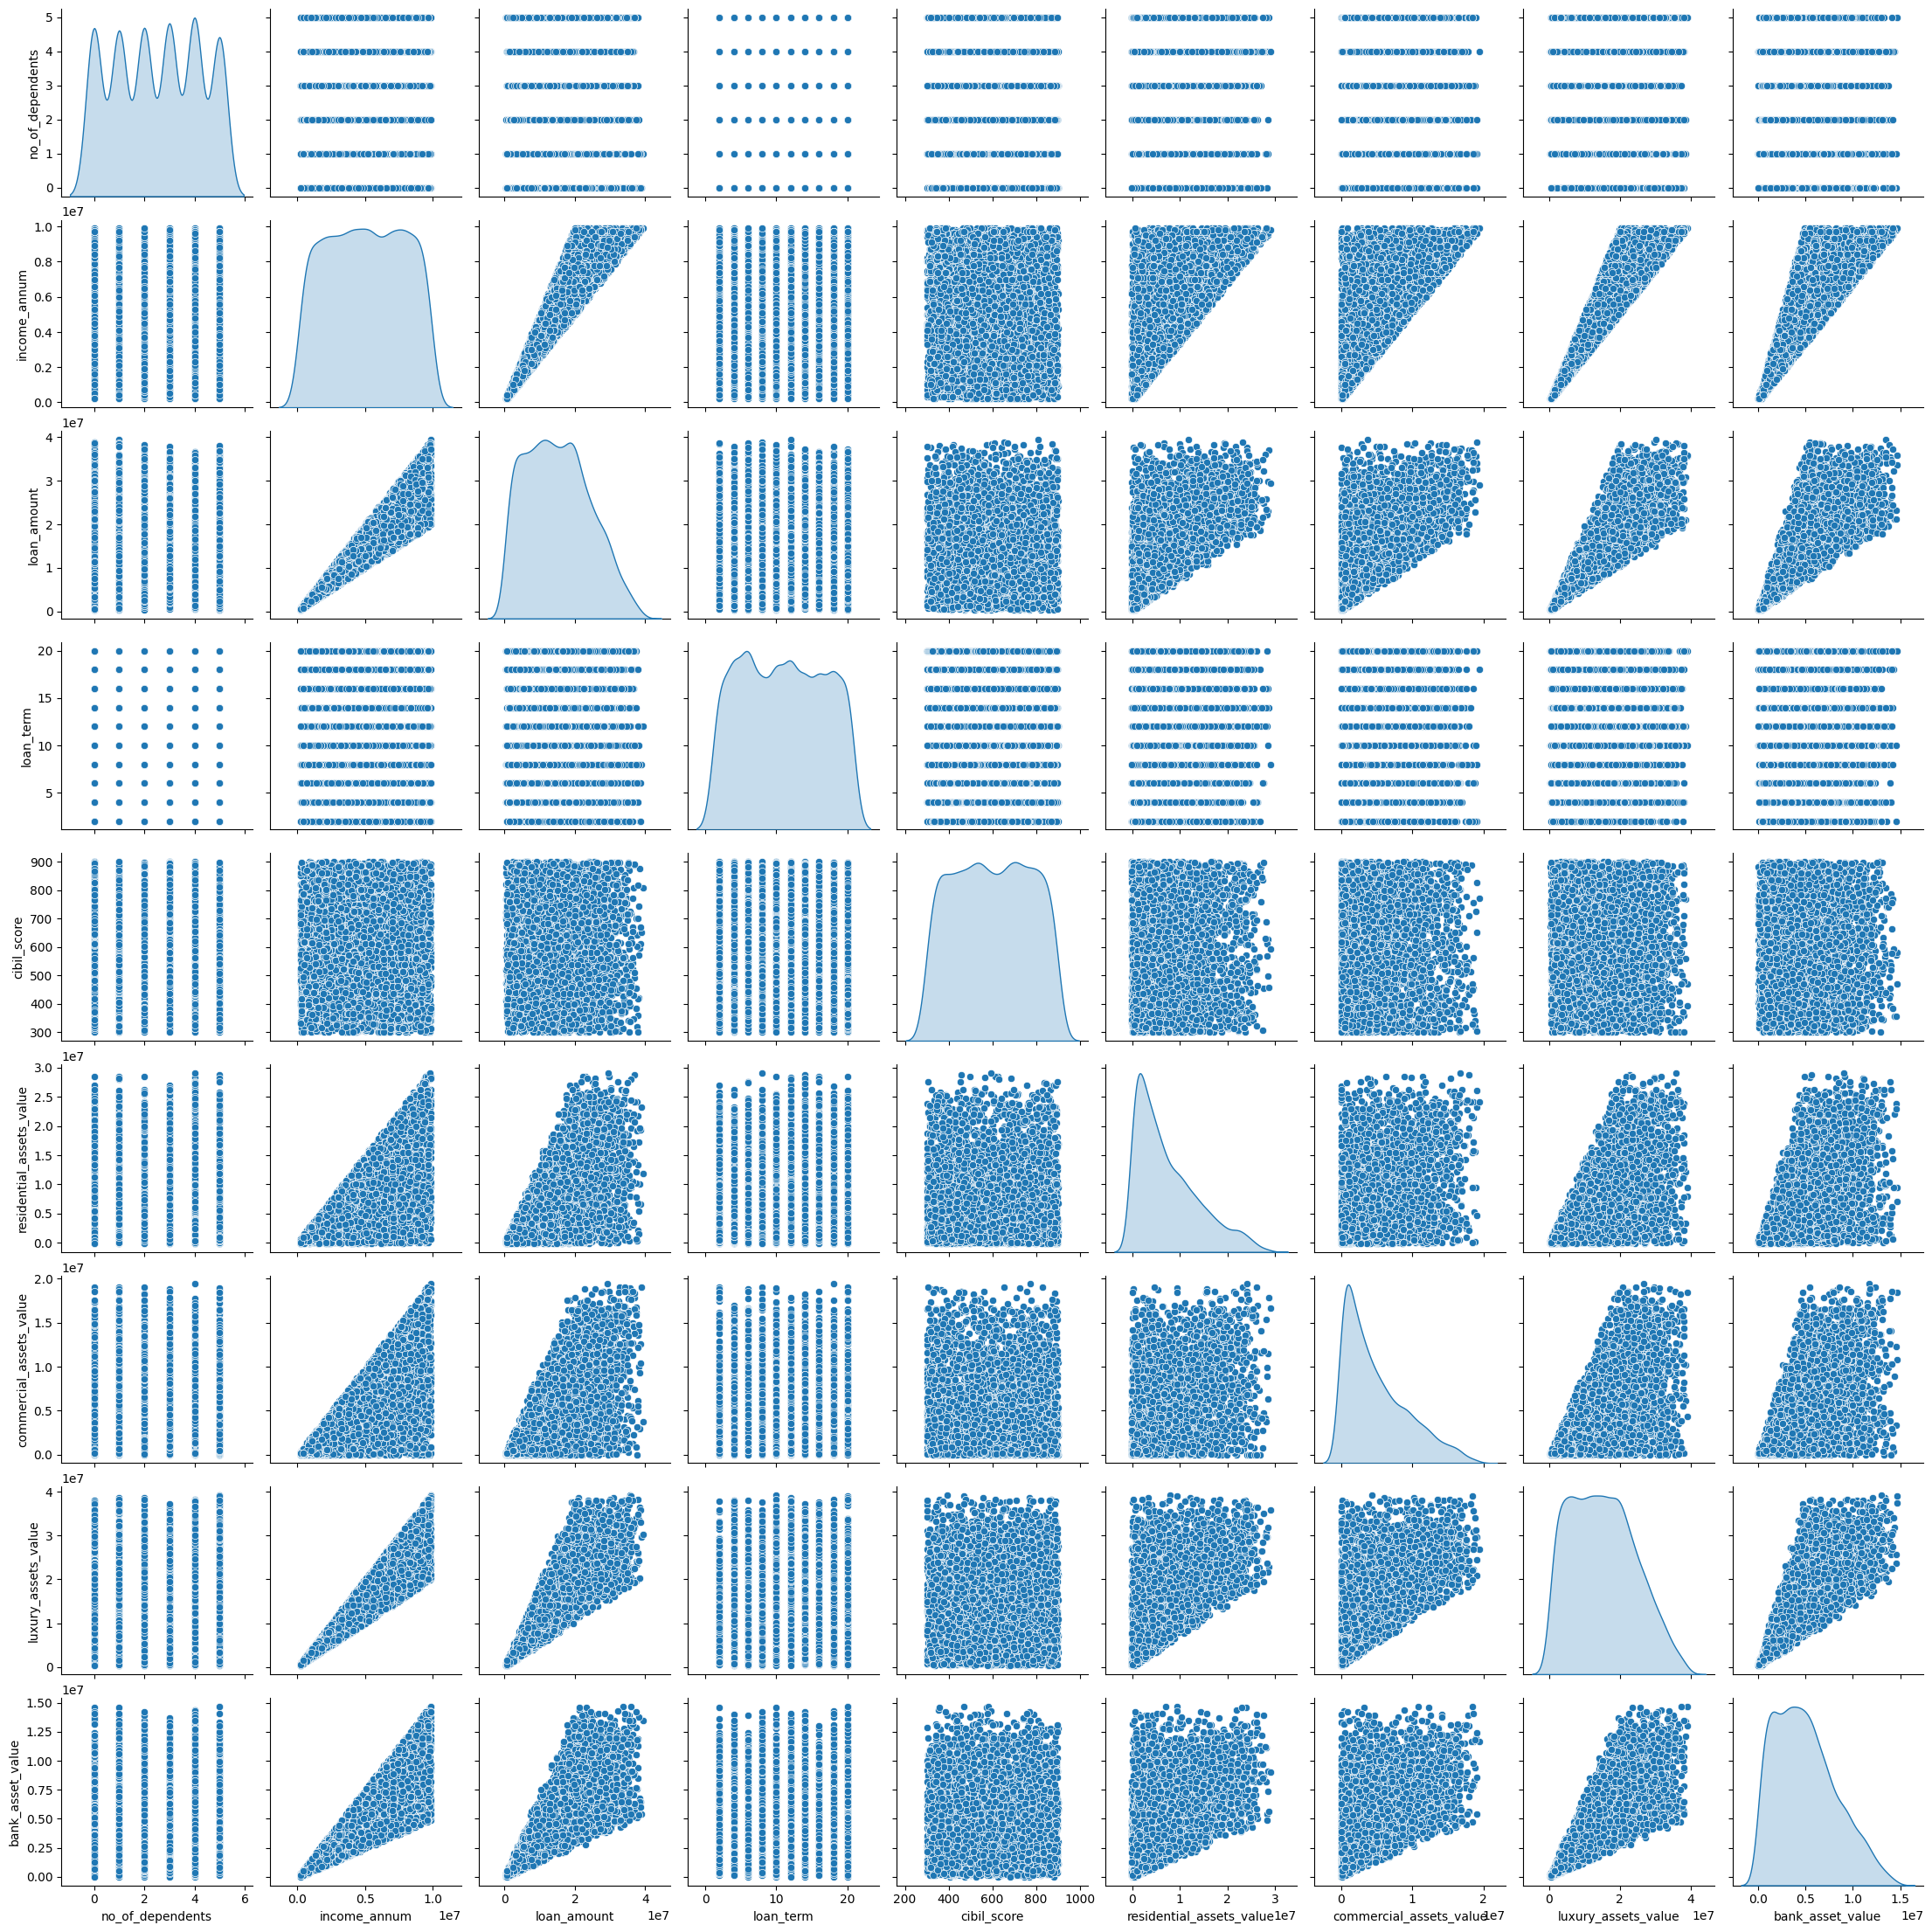

In [28]:
# Explore the relationships among all numerical variables with a pairplot
sns.pairplot(data=df, diag_kind='kde')

*Note: From the pairplots, it can be noticed that there are varying degrees of collinearity between some of the numerical features. This is further investigated through the correlation matrix below.*

In [29]:
# Explore the correlation between numerical variables through a correlation matrix
corr = df[num_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
no_of_dependents,1.000000,0.007266,-0.003366,-0.020111,-0.009998,0.007376,-0.001531,0.002817,0.011163
income_annum,0.007266,1.000000,0.927470,0.011488,-0.023034,0.636841,0.640328,0.929145,0.851093
loan_amount,-0.003366,0.927470,1.000000,0.008437,-0.017035,0.594596,0.603188,0.860914,0.788122
loan_term,-0.020111,0.011488,0.008437,1.000000,0.007810,0.008016,-0.005478,0.012490,0.017177
cibil_score,-0.009998,-0.023034,-0.017035,0.007810,1.000000,-0.019947,-0.003769,-0.028618,-0.015478
residential_assets_value,0.007376,0.636841,0.594596,0.008016,-0.019947,1.000000,0.414786,0.590932,0.527418
commercial_assets_value,-0.001531,0.640328,0.603188,-0.005478,-0.003769,0.414786,1.000000,0.591128,0.548576
luxury_assets_value,0.002817,0.929145,0.860914,0.012490,-0.028618,0.590932,0.591128,1.000000,0.788517
bank_asset_value,0.011163,0.851093,0.788122,0.017177,-0.015478,0.527418,0.548576,0.788517,1.000000


*Note: From the correlation matrix, high correlations can be noticed between the following variables:*
- *loan_amount and income_annum (0.93)*
- *luxury_assets_value and income_annum (0.93)*
- *bank_asset_value and income_annum (0.85)*
- *luxury_assets_value and loan_amount (0.86)*
- *bank_asset_value and loan_amount (0.79)*

*Multicollinearity will be further explored below in the Data Preparation phase.*

## 3. Data Preparation

In [30]:
# Apply one-hot encoding on categorical variables to suit logistic regression, LDA, KNN and SVC
df_processed = pd.get_dummies(df, columns=cat_columns, drop_first=True)
df_processed.head()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_ Not Graduate,self_employed_ Yes
loan_id,,,,,,,,,,,,
1,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,False,False
2,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,True,True
3,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,False,False
4,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,False,False
5,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,True,True


In [31]:
# Transform the target variable 'loan_status' to binary values for better preparation for f1 scoring, after stripping leading/trailing spaces
df_processed['loan_status'] = df_processed['loan_status'].str.strip().map({'Approved': 1, 'Rejected': 0})
df_processed.head()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_ Not Graduate,self_employed_ Yes
loan_id,,,,,,,,,,,,
1,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,False,False
2,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,True,True
3,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,False,False
4,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,False,False
5,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,True,True


In [38]:
# Remove negative values from 'residential_assets_value' column
df_processed = df_processed[df_processed['residential_assets_value'] >= 0]
df_processed['residential_assets_value'].describe()

count    4.241000e+03
mean     7.522613e+06
std      6.495800e+06
min      0.000000e+00
25%      2.200000e+06
50%      5.700000e+06
75%      1.140000e+07
max      2.910000e+07
Name: residential_assets_value, dtype: float64

In [39]:
# Apply standardization to the numerical variables to better suit logistic regression, LDA, KNN and SVC
scaler = StandardScaler()
df_processed[num_columns] = scaler.fit_transform(df_processed[num_columns])
df_processed.head()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_ Not Graduate,self_employed_ Yes
loan_id,,,,,,,,,,,,
1,-0.293734,1.614704,1.629681,0.192325,1.035164,-0.788697,2.872903,0.827918,0.925949,1,False,False
2,-1.473397,-0.347595,-0.329709,-0.508407,-1.060542,-0.742508,-0.634282,-0.700622,-0.520600,0,True,True
3,0.296098,1.436313,1.607541,1.593790,-0.543872,-0.065067,-0.110481,1.993567,2.403277,0,False,False
4,0.296098,1.115210,1.718241,-0.508407,-0.770278,1.643931,-0.383768,0.893898,0.895172,0,False,False
5,1.475761,1.686060,0.998691,1.593790,-1.263726,0.750941,0.732154,1.564696,0.002620,0,True,True


In [40]:
# Check for multicollinearity using the Variance Inflation Factor (VIF), in preparation for its treatment to suit logistic regression, LDA and SVC
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_processed[num_columns].values, i) for i in range(df_processed[num_columns].shape[1])]
vif['feature'] = num_columns
vif = vif.sort_values('VIF', ascending=False)
vif

,VIF,feature
1,17.545394,income_annum
7,7.278283,luxury_assets_value
2,7.132743,loan_amount
8,3.615895,bank_asset_value
6,1.692938,commercial_assets_value
5,1.683335,residential_assets_value
0,1.001641,no_of_dependents
4,1.001454,cibil_score
3,1.001178,loan_term


*Note: From the VIF scores above, it can be detected that income_annum (annual income) has severe multicollinearity (18), while luxury_assets_value and loan_amount have high multicollinearity with a score of 7.*

*Since loan_amount can be considered an essential feature in the desired system for interpretability, and since the other two features, income_annum and luxury_assets_value, do not clearly contribute to the target variable (based on the EDA above), income_annum and luxury_assets_value can be dropped to treat multicollinearity in the independent variables.*

In [41]:
# Drop the 'income_annum' and 'luxury_assets_value' columns due to high VIF from the processed dataframe and numerical column names list
df_processed = df_processed.drop(['income_annum', 'luxury_assets_value'], axis=1)
num_columns = num_columns.drop(['income_annum', 'luxury_assets_value'])

In [42]:
# Check for multicollinearity after dropping 'income_annum' and 'luxury_assets_value'
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_processed[num_columns].values, i) for i in range(df_processed[num_columns].shape[1])]
vif['feature'] = num_columns
vif = vif.sort_values('VIF', ascending=False)
vif

,VIF,feature
1,3.258201,loan_amount
6,2.720998,bank_asset_value
5,1.611677,commercial_assets_value
4,1.575829,residential_assets_value
2,1.001132,loan_term
0,1.001122,no_of_dependents
3,1.000588,cibil_score


## 4. Modeling

In [43]:
# Split the data into features (X) and target (Y)
X = df_processed.drop(columns='loan_status').values
Y = df_processed['loan_status'].values
display(X)
display(Y)

array([[-0.2937336993635892, 1.6296807199438879, 0.19232545595658013,
        ..., 0.9259494977149795, False, False],
       [-1.4733971643266404, -0.3297089748087064, -0.5084067250673514,
        ..., -0.5206003022790149, True, True],
       [0.2960980331179365, 1.607540723393011, 1.5937898180044432, ...,
        2.403276953027995, False, False],
       ...,
       [-0.2937336993635892, 0.9654808234175847, 1.2434237274924773, ...,
        0.7105059104818313, True, False],
       [-0.8835654318451148, -0.2632889851560761, -0.5084067250673514,
        ..., 0.248841080696514, True, False],
       [-0.8835654318451148, 1.607540723393011, -0.1580406345553856, ...,
        2.157055710475826, False, False]], shape=(4241, 9), dtype=object)

array([1, 0, 0, ..., 0, 1, 1], shape=(4241,))

In [44]:
# Set the random seed for reproducibility
seed = 888

# Preparate the list of the classifiers to be evaluated
models = []
models.append(('LR', LogisticRegression(max_iter=100, class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(class_weight='balanced', random_state=seed)))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC(class_weight='balanced')))
models.append(('RF', RandomForestClassifier(class_weight='balanced', random_state=seed)))
models.append(('VC', VotingClassifier(
                                    estimators=[
                                        ('LR', LogisticRegression(class_weight='balanced')),
                                        ('RF', RandomForestClassifier(class_weight='balanced', random_state=seed))], 
                                        voting = 'soft')))

## 5. Evaluation

C:\Users\Islam Salahuddin\AppData\Local\Temp\ipykernel_3368\3040090827.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([comparison, pd.DataFrame({


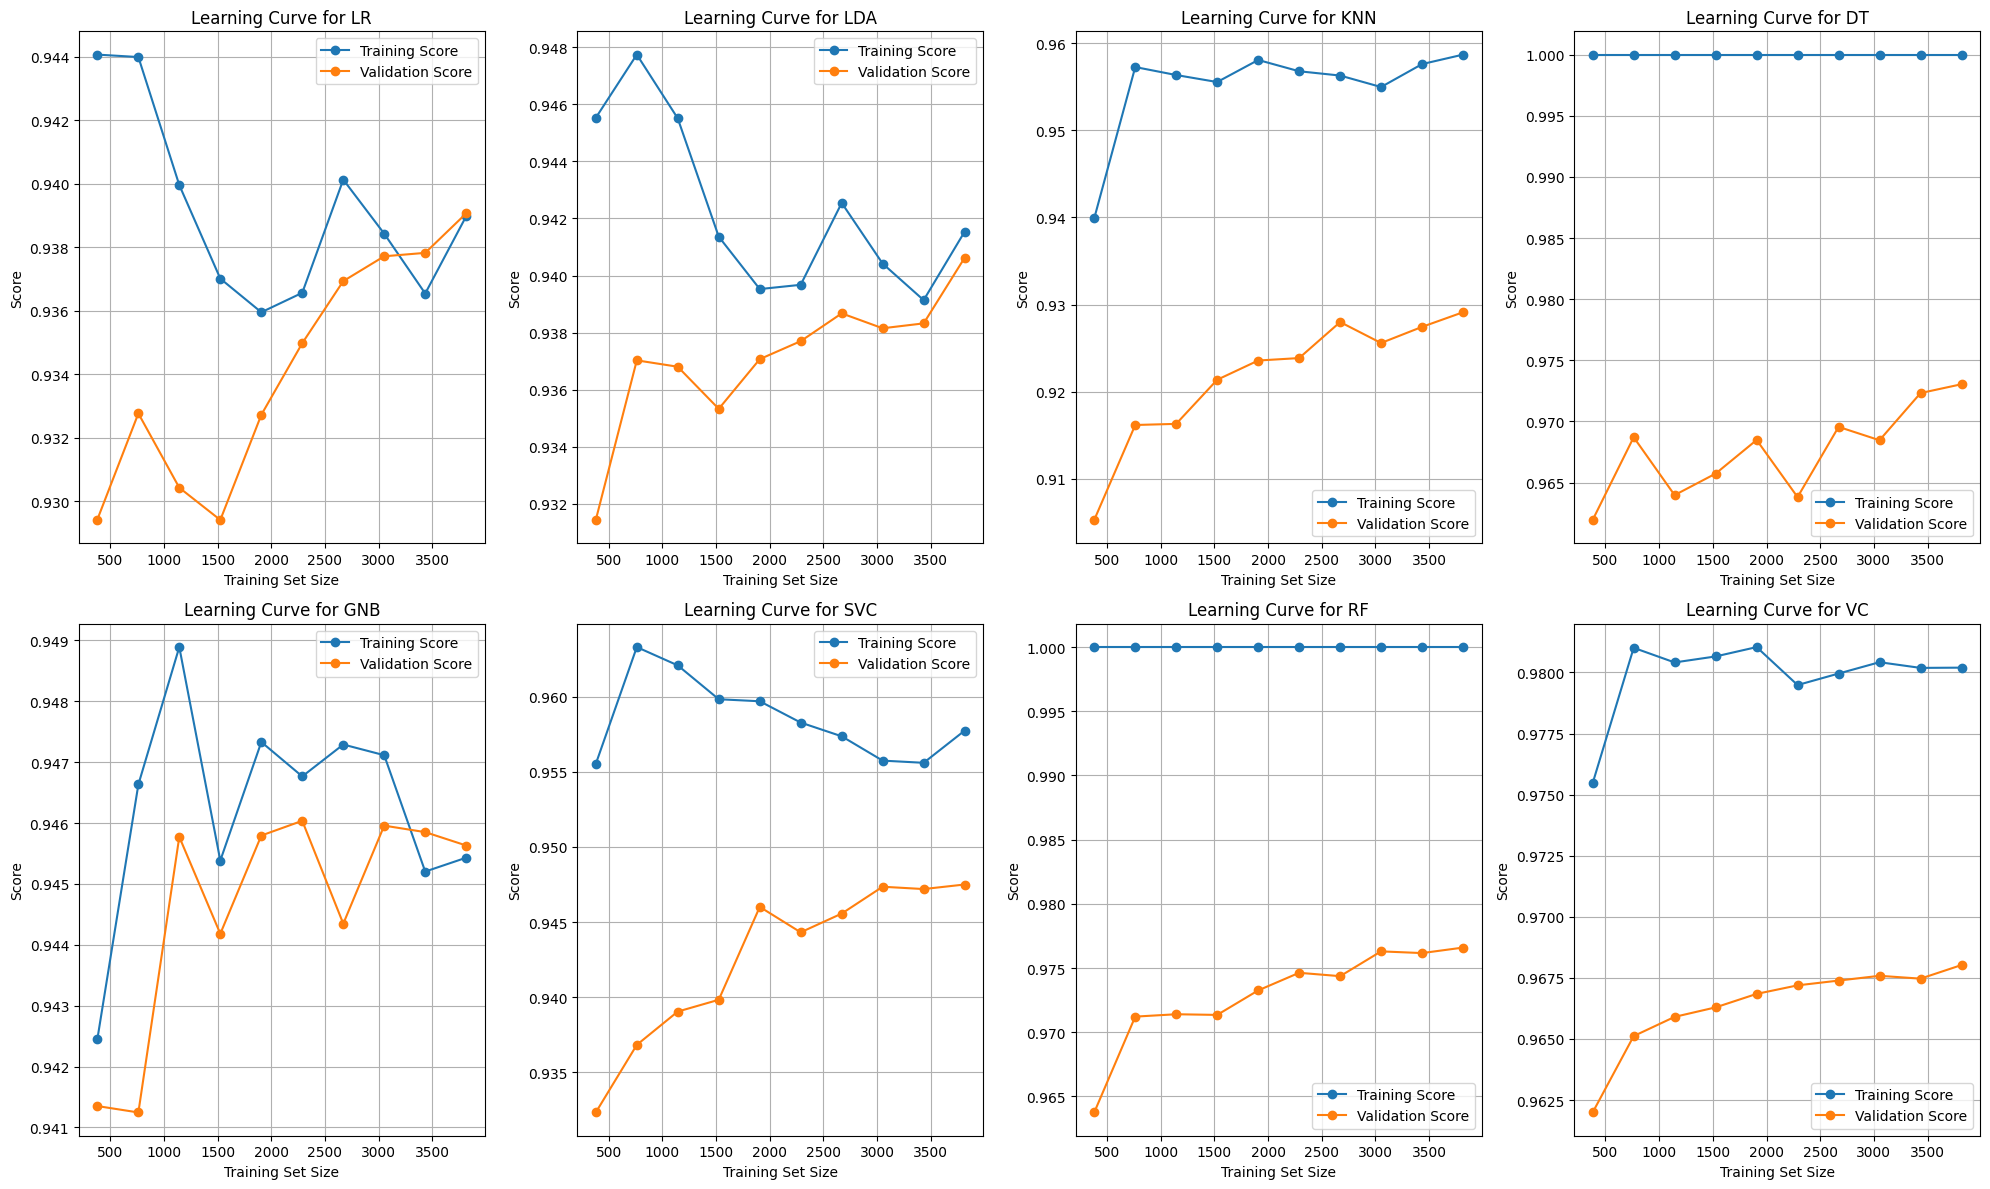

In [45]:
# Initiate lists and a dataframe to store the results
results = []
names = []
comparison = pd.DataFrame(columns=['Model', 'F1 Scores Mean', 'Standard Deviation',\
								    'Train F1 Scores Mean', 'Validation F1 Scores Mean', 'Train Validation Diff'])

# Set the scoring method for the classifiers
scoring = 'f1'

# Initiate the canvas for the learning curve plots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.ravel()

# Loop through each model, perform cross-validation, and plot the learning curves
for i, (name, model) in enumerate(models):
	# Define K-Fold and cross-validation
	kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
	# Generate learning curve data
	train_sizes, train_scores, validation_scores = learning_curve(model, X, Y, cv=kfold, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), random_state=seed)

    # Calculate mean scores for training and validation sets
	train_scores_mean = train_scores.mean(axis=1)
	validation_scores_mean = validation_scores.mean(axis=1)

	# Evaluate model performance using cross-validation
	cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	
	# Store the results
	results.append(cv_results)
	names.append(name)

	# Create a comparison dataframe
	comparison = pd.concat([comparison, pd.DataFrame({
		'Model': name,
		'F1 Scores Mean': cv_results.mean(),
		'Standard Deviation': cv_results.std(),
		'Train F1 Scores Mean': train_scores_mean,
		'Validation F1 Scores Mean': validation_scores_mean,
		'Train Validation Diff': train_scores_mean - validation_scores_mean
	})], ignore_index=True)
    
	# Plot the learning curves
	axes[i].plot(train_sizes, train_scores_mean, label='Training Score', marker='o')
	axes[i].plot(train_sizes, validation_scores_mean, label='Validation Score', marker='o')
	axes[i].set_title(f'Learning Curve for {name}')
	axes[i].set_xlabel('Training Set Size')
	axes[i].set_ylabel('Score')
	axes[i].legend()
	axes[i].grid()

# Adjust and display the plots
plt.tight_layout()
plt.show()


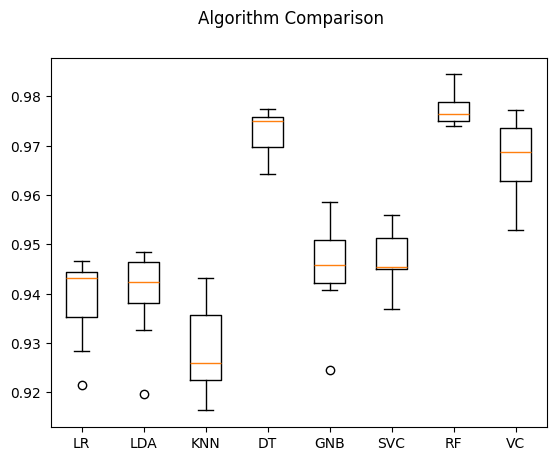

,F1 Scores Mean,Standard Deviation,Train F1 Scores Mean,Validation F1 Scores Mean,Train Validation Diff
Model,,,,,
RF,0.977,0.003,1.000,0.973,0.027
DT,0.972,0.005,1.000,0.968,0.032
VC,0.968,0.007,0.980,0.966,0.013
SVC,0.947,0.006,0.959,0.943,0.016
GNB,0.946,0.009,0.946,0.945,0.002
LDA,0.940,0.008,0.942,0.937,0.005
LR,0.939,0.008,0.939,0.934,0.005
KNN,0.929,0.009,0.955,0.922,0.033


In [46]:
# Display a plot for the overall f1 scores for all the algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Display the comparison dataframe
comparison = comparison.groupby('Model').agg('mean').round(3)
display(comparison.sort_values(by=['F1 Scores Mean', 'Train Validation Diff'], ascending=[False, True]))

## 6. Presentation

### 6.1 Findings and Conclusion
The results above show that the top three performing models are Random Forest (RF), Decision Tree Classifier (DT) and Voting Classifier (VC) with Logistic Regression and Random Forest, with f1 scores of 97.8%, 97.1% and 96.8% respectively. 

These results partially align with the findings of [S. Srivastava (2024)](https://ieeexplore.ieee.org/document/10866059), where ensemble algorithms, Random Foerst and Voting Classifier emerged as the best algorithms on the basis of accuracy. However, in this case, scoring based on f1 score, Decision Trees show up as a strong candidate as well.

Regarding overfitting, both Random Forest and Decision Tree Classifier exhibit overfitting behavior with train scores sticking to 100% and a relatively high difference between train and validation scores of about 3%. On the other hand, Voting Classifier showed less tendency for overfitting with about 1% difference between train and validation scores.

### 6.2 Recommendations
Following the above results, I would recommend implementing **Voting Classifier** with Logistic Regression and Random Forest, as it exhibits less tendency to overfit, while maintaining a high f1 score.

Decision Trees and Random Forest would still be viable options for their interpretability and highest score respectively. However, they would both need further hyperparameter tuning and cross validation to attempt treating overfitting.